<a href="https://colab.research.google.com/github/ShivakumarRavi/TravelAssistant-/blob/main/TravelAssistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TravelAssist AI
## **Part 1: Introduction**

Project Background
In today's busy and fast paced life, everyone wants a quick escape every now and then in form of a holiday. However, the overwhelming number of choices and the lack of personalized assistance can make the holiday planning daunting. To address this, we have developed TravelAssist AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery.

**Problem Statement**
Given a dataset containing information about holiday packages (Package name, destination, No. of days, Sighseeing etc.), build a chatbot that parses the dataset and provides accurate holiday recommendations based on user requirements.

## **Part 2: System Design**
**Dataset**

We have a dataset travel_data.csv where each row describes the features of a holiday package. The chatbot that we build will leverage LLMs to converse with user to identify their specific needs and then recommend the matching holiday packages from the dataset

**Building the Chatbot**

Now let's go ahead and understand the system design for the chatbot.

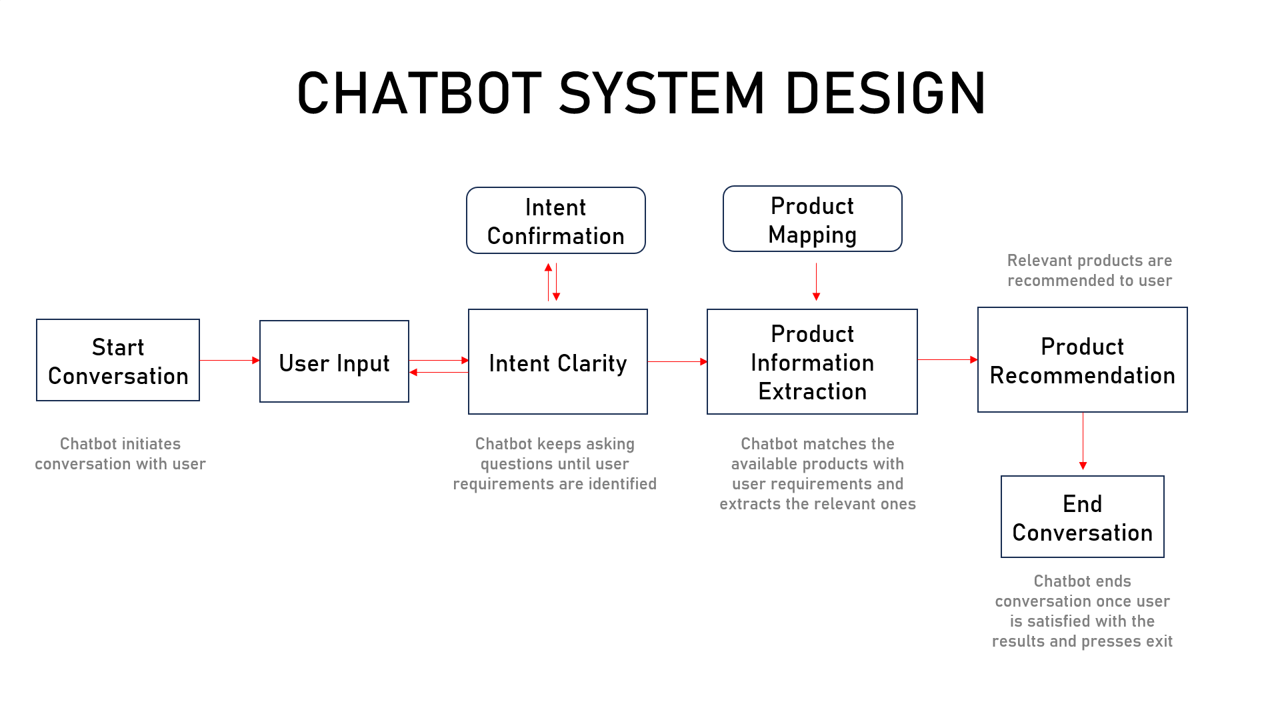

As shown in the image, the chatbot contains the following layers:

- Intent Clarity Layer
- Intent Confirmation Layer
- Product Mapping Layer
- Product Information Extraction Layer
- Product Recommendation Layer

Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later

- initialize_conversation(): This initializes the variable conversation with the system message.
- get_chat_model_completions(): This takes the ongoing conversation as the input and returns the response by the assistant
- moderation_check(): This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- intent_confirmation_layer(): This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not 'Destination','Package','Origin','Duration','Budget'
- dictionary_present(): This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- compare_holiday_with_user(): This function compares the user's requirements with the different holiday packages and come back with the top 3 recommendations.
- initialize_conv_reco(): Initializes the recommendations conversation

## **Part 3: Implementation**
### 3.1 - Import the libraries
Let's start by importing the libraries that we'll require for this project. Following are the ones:

openai,
pandas,
os, json, ast

In [1]:
!pip install openai==0.28.0

In [2]:
import os,json,ast
import openai
import pandas as pd
import certifi
import ssl

In [11]:
# Initialize the client with a custom requestor that uses the requests library
# class CustomAPIRequestor(APIRequestor):
#     def request(self, *args, **kwargs):
#         kwargs["verify"] = certifi.where()
#         return super().request(*args, **kwargs)

In [12]:
openai.api_key = open("key.txt", "r").read().strip()

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers
Let's start with the first part of the implementation - building the intent clarity and intent confirmation layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- initialize_conversation(): This initializes the variable conversation with the system message. used prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [4]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"
    example_user_req = {'Destination': 'Manali','Package': 'Deluxe','Origin': 'New Delhi','Duration': '4','Budget': '15000 INR'}

    system_message = f"""

    You are an intelligent holiday planner and your goal is to find the best holiday package for a user.
    You need to ask relevant questions and understand the user preferences by analysing the user's responses.
    You final objective is to fill the values for the different keys ('Destination','Package','Origin','Duration','Budget') in the python dictionary and be confident of the values.
    These key value pairs define the user's preference.
    The python dictionary looks like this {{'Destination': 'values','Package': 'values','Origin': 'values','Duration': 'values','Budget': 'values'}}

    The value for all the keys should be extracted from the user's response.
    The values currently in the dictionary are only representative values.

    {delimiter}Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised.
    - The value for 'Budget' should be a numerical value extracted from the user's response.
    - 'Budget' value needs to be greater than or equal to 6500 INR. If the user says less than that, please mention that there are no holiday packages in that range.
    - The value for 'Duration' should be a numerical value extracted from the user's response.
    - 'Origin' value can either be 'Mumbai' or 'New Delhi'. If the user mentions any other city, please mention that we are travel company dealing in holidays only from Mumbai and New Delhi
    - For 'Package', give user the option whether they want to go for a 'Premium', 'Deluxe' , 'Luxury' or 'Standard' option.
    - Do not randomly assign values to any of the keys. The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    {delimiter} Thought 1: Ask a question to understand the user's preference for the holiday destination and number of nights. \n
    If their primary destination is unclear. Ask another question to comprehend their needs.
    You are trying to fill the values of all the keys ('Destination','Package','Origin','Duration','Budget') in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    Answer "Yes" or "No" to indicate if you understand the requirements and have updated the values for the relevant keys. \n
    If yes, proceed to the next step. Otherwise, rephrase the question to capture their requirements. \n{delimiter}

    {delimiter}Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys. Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    Answer "Yes" or "No" to indicate if you understood all the values for the keys and are confident about the same.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.{delimiter}

    {delimiter}Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions. {delimiter}

    Follow the above chain of thoughts and only output the final updated python dictionary. \n


    {delimiter} Here is a sample conversation between the user and assistant:
    User: "Hi, I want to visit Manali."
    Assistant: "Great! For what duration would you like to visit Manali"
    User: "I would like to visit for 4 nights."
    Assistant: "Thank you for providing that information. Which of the below package would you like to opt for:
    Standard
    Premium
    Deluxe
    Luxury"
    User: "I would like to go with Deluxe"
    Assistant: "Thank you for the information. Could you please let me know whether your origin city would be New Delhi or Mumbai?"
    User: "i'll start from New Delhi"
    Assistant:"Great, thanks. Could you kindly let me know your per person budget for the holiday package? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 15000 inr"
    Assistant: "{example_user_req}"
    {delimiter}

    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    return conversation

In [5]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n\n    You are an intelligent holiday planner and your goal is to find the best holiday package for a user.\n    You need to ask relevant questions and understand the user preferences by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'Destination\',\'Package\',\'Origin\',\'Duration\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s preference.\n    The python dictionary looks like this {\'Destination\': \'values\',\'Package\': \'values\',\'Origin\': \'values\',\'Duration\': \'values\',\'Budget\': \'values\'}\n    \n    The value for all the keys should be extracted from the user\'s response.\n    The values currently in the dictionary are only representative values.\n\n    ####Here are some instructions around the values for the different keys. If you do not follow this, you\'ll be heavily penalised.\n    - The value for \'Budget\'

Building the next function

- get_chat_model_completions(): This takes the ongoing conversation as the input and returns the response by the assistant

In [6]:
def get_chat_model_completions(messages):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0,
        max_tokens = 2500
    )
    return response.choices[0].message["content"]

Let's pass the initialized conversation debug_conversation and see what is the assistant's response.

In [9]:
debug_introduction = get_chat_model_completions(debug_conversation)
print(debug_introduction)

Welcome! I'm here to help you find the best holiday package. Please share your holiday preferences with me.


We can play around a bit and add the following user's input debug_user_input to the conversation debug_conversation and see what the assistant responds with.

In [15]:
debug_user_input = "Hi, I am Anand. I want to visit Cochin."


In [22]:
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_model_completions(debug_conversation)
print(debug_response_assistant)

Great! For what duration would you like to visit Cochin?


In [23]:
debug_user_input = "i would like to visit for 4 nights"

In [24]:
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_model_completions(debug_conversation)
print(debug_response_assistant)

Great! For what duration would you like to visit Cochin?


In [25]:
debug_user_input = "i'd go with Standard"

In [26]:
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_model_completions(debug_conversation)
print(debug_response_assistant)

Thank you for providing that information. Could you please let me know whether your origin city would be New Delhi or Mumbai?


In [27]:
debug_user_input = "New Delhi"

In [28]:
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_model_completions(debug_conversation)
print(debug_response_assistant)

Great! Could you please let me know your per person budget for the holiday package? This will help me find options that fit within your price range while meeting the specified requirements.


In [29]:
debug_user_input = 'my max budget is 36000 INR'

In [30]:
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_model_completions(debug_conversation)
print(debug_response_assistant)

{'Destination': 'Cochin', 'Package': 'Standard', 'Origin': 'New Delhi', 'Duration': '4', 'Budget': 36000}


Typically, whenever the chatbot is interacting with the user, all the conversations should be moderated to identify any inappropriate content. Let's look at the function that can help with it.
- moderation_check(): This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, one can add a break statement to end the conversation.

In [31]:
def moderation_check(user_input):
    response = openai.Moderation.create(input=user_input)
    moderation_output = response["results"][0]
    if moderation_output["flagged"] == True:
        return "Flagged"
    else:
        return "Not Flagged"

Let's test moderation on the debug_user_input

In [32]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


Let's now test moderation on some other text.

Let's now check moderation on the assistant's response debug_response_assistant.

In [33]:
moderation_check(debug_response_assistant)

'Not Flagged'

intent_confirmation_layer(): This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
- Destination
- Package
- Origin
- Duration
- Budget

In [40]:
def intent_confirmation_layer(response_assistant):
    delimiter = "####"
    prompt = f"""
    You are a senior evaluator who has an eye for detail.
    You are provided an input. You need to evaluate if the input has the following keys: 'Destination','Package','Origin','Duration','Budget'
    Next you need to evaluate if the keys have the the values filled correctly.
    - The value for the key 'Budget' needs to contain a number with currency.
    - The value of key 'Package' needs to be either  'Premium', 'Deluxe' , 'Luxury' or 'Standard'
    - The value of key 'Duration' needs to contain a number
    - The value of key 'Origin' should either be 'New Delhi' or 'Mumbai'
    Output a string 'Yes' if the input contains the dictionary with the values correctly filled for all keys.
    Otherwise out the string 'No'.

    Here is the input: {response_assistant}
    Only output a one-word string - Yes/No.
    """


    confirmation = openai.Completion.create(
                                    model="gpt-3.5-turbo-instruct",
                                    prompt = prompt,
                                    temperature=0)


    return confirmation["choices"][0]["text"]

Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [41]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
print(debug_confirmation)


Yes


Now, you can keep adding user and assistant responses to debug_conversation and get to a point where intent_confirmation_layer()
- dictionary_present(): This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right holiday packages using dictionary matching.

In [43]:
def dictionary_present(response):
    delimiter = "####"
    user_req = {'Destination': 'Manali','Package': 'Deluxe','Origin': 'New Delhi','Duration': '4','Budget': '15000 INR'}
    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract and return only the python dictionary from the input.
            The output should match the format as {user_req}.
            The output should contain the exact keys and values as present in the input.

            Here are some sample input output pairs for better understanding:
            {delimiter}
            input: - Destination: Manali - Package: Luxury - Origin: Delhi - Duration: 4 - Budget: 50,000 INR
            output: {{'Destination': 'Manali', 'Package': 'Luxury', 'Origin': 'New Delhi', 'Duration': '4', 'Budget': '50000'}}

            input: {{'Destination':     'jaipur', 'Package':     'Standard', 'Origin':    'Mumbai', 'Duration': '4','Budget': '90,000'}}
            output: {{'Destination': 'Jaipur', 'Package': 'Standard', 'Origin': 'Mumbai', 'Duration': '4', 'Budget': '90000'}}

            input: Here is your user profile 'Destination': 'Ooty','Package': 'Deluxe','Origin': 'New Delhi','Duration': '5','Budget': '100000 INR'
            output: {{'Destination': 'Ooty', 'Package': 'Deluxe', 'Origin': 'New Delhi', 'Duration': '5', 'Budget': '100000'}}
            {delimiter}

            Here is the input {response}

            """
    response = openai.Completion.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        max_tokens = 2000
        # temperature=0.3,
        # top_p=0.4
    )
    return response["choices"][0]["text"]

Let's start by passing the debug_response_assistant.

In [44]:
response_dict_n = dictionary_present(debug_response_assistant)
print(response_dict_n)

 and it's your task to return {'Destination': 'Cochin', 'Package': 'Standard', 'Origin': 'New Delhi', 'Duration': '4', 'Budget': '36000'}

            The output should match the format as {'Destination': 'Cochin', 'Package': 'Standard', 'Origin': 'New Delhi', 'Duration': '4', 'Budget': '36000'}.


{'Destination': 'Cochin', 'Package': 'Standard', 'Origin': 'New Delhi', 'Duration': '4', 'Budget': '36000'}


What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

In [45]:
debug_response_assistant_n = f"""Thank you for providing your budget. Based on your budget of 50,000 INR, I will consider this while recommending suitable laptop options for you.
Here is the final recommendation for your laptop:

- Destination: Cochin
- Package: Standard
- Origin: Mumbai
- Duration: 7
- Budget: 80,000 INR

Please note that these specifications are based on your requirements for surfing and a decent display within your budget. Let me know if there's anything else I can assist you with!"""

In [46]:
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)


{'Destination': 'Cochin', 'Package': 'Standard', 'Origin': 'Mumbai', 'Duration': '7', 'Budget': '80000'}


### 3.3 Implementing the Product Mapping and Information Extraction Layers
In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary, and extract the relevant holiday recommendations based on that. Here are the functions that we will use to help us implement the information extraction and product matching layers
- product_map_layer(): This function is responsible for extracting key features and criteria from holiday package dataset. Here's a breakdown of how it works:
 - Uses a prompt that assign it the role of a holiday expert, whose objective is to extract key features as per requirements
 - Assign specific rules for each feature.
 - Includes Few Shot Prompting(sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction.

In [47]:
def product_map_layer(Destination,Package,Origin,Duration):

  delimiter = "#####"
  holiday_spec = {
      "Destination":"(Holiday destination)",
      "Package":"(Type of the holiday package)",
      "Origin":"(Origin city of the holiday)",
      "Duration":"(Maximum duration of the holiday)"

  }


  prompt=f"""
  You are a Holiday expert whose job is to extract the key features of a holiday package as per their requirements.
  Extract all the features above acccording to following rules: \
  {delimiter}
  Destination: Extract the first word until you find '|'. If there is only one word, extract the same from {Destination}

  Package: Extract the exact value from {Package}

  Origin: Extract the exact value from {Origin}

  Duration: Add all the numbers you find and output the sum from {Duration}

  {delimiter}

  {delimiter}
  Here are some input output pairs for few-shot learning:
  input1: "Gangtok|Lachung|Gangtok|Darjeeling, Deluxe, New Delhi, 2N Gangtok . 2N Lachung . 1N Gangtok . 2N Darjeeling"
  output1: {{'Destination': 'Gangtok','Package':'Deluxe','Origin':'New Delhi','Duration':'7'}}

  input2: "Cochin|Munnar|Thekkady|Allepey|Kovalam and Poovar, Standard, Mumbai, 1N Cochin . 2N Munnar . 1N Thekkady . 1N Allepey . 2N Kovalam and Poovar"
  output2: {{'Destination': 'Cochin','Package':'Standard','Origin':'Mumbai','Duration':'7'}}

  input3: "Dharamshala, Deluxe, New Delhi, 3N Dharamshala"
  output3: {{'Destination': 'Dharamshala','Package':'Deluxe','Origin':'New Delhi','Duration':'3'}}
  {delimiter}

  Follow the above instructions step-by-step and output only the dictionary {holiday_spec} without any additional text for the following holiday package {Destination,Package,Origin,Duration}.
  """

#see that we are using the Completion endpoint and not the Chatcompletion endpoint

  response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",
    prompt=prompt,
    max_tokens = 2000,
    # temperature=0.3,
    # top_p=0.4
    )
  return response["choices"][0]["text"]

- extract_dictionary_from_string(): This function takes in the output of the previous layer and extracts the user requirements dictionary

In [48]:
import ast
import re

def extract_dictionary_from_string(string):
    regex_pattern = r"\{[^{}]+\}"

    dictionary_matches = re.findall(regex_pattern, string)

    # Extract the first dictionary match and convert it to lowercase
    if dictionary_matches:
        dictionary_string = dictionary_matches[0]
        dictionary_string = dictionary_string.lower()

        # Convert the dictionary string to a dictionary object using ast.literal_eval()
        dictionary = ast.literal_eval(dictionary_string)
    return dictionary

- compare_holiday_with_user(): This function compares the user's profile with the different holiday packages and come back with the top recommendations. It will perform the following steps:
 - It will take the user requirements dictionary as input
 - Filter the holidays based on their per person budget, keeping only the ones within the user's budget.
 - Match the user requirement with holiday data.
 - Return the matching holidays as a JSON-formatted string.

In [50]:
def compare_holiday_with_user(user_req_string):

    holiday_df= pd.read_csv('data.csv')

    ## Create a new column "holiday_feature" that contains the dictionary of the product features
    holiday_df['holiday_feature'] = holiday_df.apply(lambda x: product_map_layer(x['Destination'], x['Package Type'], x['Start City'], x['Itinerary']), axis = 1)

    #extract user requirements into a dictionary
    user_requirements = extract_dictionary_from_string(user_req_string)

    #This line retrieves the value associated with the key 'budget' from the user_requirements dictionary.
    #If the key is not found, the default value '0' is used.
    #The value is then processed to remove commas, split it into a list of strings, and take the first element of the list.
    #Finally, the resulting value is converted to an integer and assigned to the variable budget.
    budget = int(user_requirements.get('budget', '0').replace(',', '').split()[0])


    #filter filtered_holiday to include only rows where the 'Per Person Price' is less than or equal to the budget.
    filtered_holiday = holiday_df.copy()
    filtered_holiday = filtered_holiday[filtered_holiday['Per Person Price'] <= budget].copy()


    #delete budget key from user requirements before comparing with holiday package
    del user_requirements['budget']

    #extract holiday packages into a dictionary so that it can be compared with user requirements
    filtered_holiday['holiday_feature'] = filtered_holiday['holiday_feature'].apply(lambda x: extract_dictionary_from_string(x))

    #comparison of user requirements with holiday packages and returning the matching rows from df
    mask = filtered_holiday['holiday_feature'] .apply(lambda x: all(x[key] == user_requirements[key] for key in user_requirements))
    result_df = filtered_holiday[mask]

    return result_df.to_json(orient='records')

Now that you have the compare_holiday_with_user() function ready, let's pass the response_dict_n to the function to get relevant recommendation.

In [51]:
recommended_holiday = compare_holiday_with_user(response_dict_n)
print(recommended_holiday)

[{"Uniq Id":"c782c902e6d370153361d708bb2bca64","Crawl Timestamp":"2019-09-25 16:15:44 +0000","Package Name":"A Relaxing holiday to Kerala - Free Speed Boat Ride","Page Url":"https:\/\/holidayz.makemytrip.com\/holidays\/india\/package?id=36501&depCityId=1268&listingClassId=8&depDateMilliSec=1569974400000","Package Type":"Standard","Company":"Makemytrip","Destination":"Cochin|Munnar|Thekkady|Allepey|Kovalam and Poovar","Itinerary":"1N Cochin . 2N Munnar . 1N Thekkady . 1N Allepey . 2N Kovalam and Poovar","Places Covered":"Cochin|Munnar|Thekkady|Allepey|Kovalam and Poovar","Travel Date":"02-10-2019","Hotel Details":"Quality Airport Hotel:4.1|Hotel Hillview, Munnar - MMT Special:4.1|Elephant Route Resort:3.8|Camelot Hotel, Alleppey- MMT Holidays Special:|Sagara Beach Resort:","Start City":"Mumbai","Airline":"Spicejet|IndiGo","Flight Stops":null,"Onwards Return Flight Time":"15 : 45-17 : 45|10 : 50-13 : 00","Meals":null,"Price Per Two Persons":"32864","Per Person Price":16432.0,"Sightseeing

### 3.4: Product Recommendation Layer
Finally, we come to the product recommendation layer. It takes the output from the compare_holiday_with_user function in the previous layer and provides the recommendations to the user. It has the following steps.

 - Initialize the conversation for recommendation.
 - Generate the recommendations and display in a presentable format.
 - Ask questions basis the recommendations.

In [52]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent holiday expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue: {products}.\
    You should keep the user requirements in mind while answering the questions.\

    Start with a brief summary of each holiday in the following format, in decreasing order of price per person:
    1. <Holiday Name> : <Major attractions of the holiday>, <Price per person in Rs>
    2. <Holiday Name> : <Major attractions of the holiday>, <Price per person in Rs>

    """
    conversation = [{"role": "system", "content": system_message }]
    return conversation

Let's initialize the conversation for recommendation.



In [53]:
debug_conversation_reco = initialize_conv_reco(recommended_holiday)

Let's see what the assistant responds with the new initialization.



In [56]:
debug_recommendation = get_chat_model_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

1. A Relaxing holiday to Kerala - Free Speed Boat Ride: Dutch Palace, Jewish Synagogue, St. Francis Church, Chinese Fishing Nets, Fort Cochin, Mattupetty Dam, Tata Tea Museum, Pothamedu View Point, Eravikulam National Park, Echo Point, Lakkam Waterfalls, Speed Boat Ride at Mattupetty Dam and Drive to Top Station in Munnar, Kalari Show, Periyar Wildlife Sanctuary, Price per person: Rs 16432.0

Now, how can I assist you further with this holiday package?



Now, you can converse with the chatbot on the filtered products.

In [57]:
#debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + response_dict_n})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [58]:
debug_user_input = "Will it cover some adventure activities?"

In [59]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_model_completions(debug_conversation_reco)
print('\n' + debug_response_asst_reco + '\n')


Yes, the holiday package includes a Speed Boat Ride at Mattupetty Dam and Drive to Top Station in Munnar, which can be considered as an adventure activity. Additionally, the package also includes a visit to Periyar Wildlife Sanctuary, where you can indulge in wildlife spotting and nature walks, adding an adventurous touch to your holiday experience.



You can repeat the process of appending the assistant and user messages and test the chatbot out.